In [2]:
import datetime
from matplotlib import pyplot as plt
from matplotlib.patches import ConnectionPatch
import pandas as pd
import plotly.express as px
import json
import time

In [3]:
def readScatterData(path):
    """ 读取所有外部存档的目标值
    """
    TotalDelay = []
    Utilization = []

    with open(path) as f:
        for line in f.readlines():
            datas = json.loads(line)
            for data in datas:
                if datas[data][0] not in TotalDelay:
                    TotalDelay.append(datas[data][0])
                if datas[data][1] not in Utilization:
                    Utilization.append(datas[data][1])

    # TotalDelay = []
    # Utilization = []

    # for map in data:
    #     TotalDelay.append(data[map][0])
    #     Utilization.append(data[map][1])

    return TotalDelay, Utilization


In [4]:
def readAllScatterData(path):
    """ 读取所有外部存档的目标值
    """

    TotalDelay = []
    Utilization = []

    with open(path) as f:
        for line in f.readlines():
            datas = json.loads(line)
            for data in datas:
                TotalDelay.append(datas[data][0])
                Utilization.append(datas[data][1])
    # for map in data:
    #     TotalDelay.append(data[map][0])
    #     Utilization.append(data[map][1])

    return TotalDelay, Utilization

In [5]:
def readtimetable(timetable):

    """记录编码"""
    code = timetable.get("code")
    ConfigurationCode = code.get("ConfigurationCode")
    OperationCode = code.get("OperationCode")
    SortCode = code.get("SortCode")
    """记录解码"""
    decode = timetable.get("decode")
    StartTime = decode.get("StartTime")
    FinishTime = decode.get("FinishTime")
    ProcessingTime = decode.get("ProcessingTime")
    SetupStartTime = decode.get("SetupStartTime")
    SetupFinishTime = decode.get("SetupFinishTime")
    
    """记录结果指标"""
    Makespan = decode.get("Makespan")
    TotalDelay = decode.get("TotalDelay")
    Utilization = decode.get("Utilization")
    R = timetable.get("R")

    return StartTime, FinishTime, ProcessingTime, SetupStartTime, SetupFinishTime, ConfigurationCode, SortCode, TotalDelay, Utilization


"""甘特图绘制，输入：
时间表：[{OP1:[T1,T2,T3...], OP2:[T4,T5...]},{...}]
解：{"ConfigurationCode":[1,3,5,2,4,7,6],"OperationCode":{"1":{"1":1,"2":2,"5":4,"6":5,"7":6,"8":6,"9":6},"2":{"1":1,"2":2,"3":2,"5":4,"6":5,"7":6,"8":6,"9":6},"3":{"2":5,"7":7,"8":7,"9":7},"4":{"2":2,"3":2,"4":4,"7":6,"8":6,"9":6},"5":{"2":3,"9":6}},"SortCode":[3,1,4,5,2]}
title：甘特图名
"""
def DrawGantt(S_table, F_table, Setup_S, Setup_F, ConfigurationCode, SortCode, title):

    struct_time = (2022, 4, 1, 8, 0, 0, 1, 152, 0)    # 2022.04.01 8:00:00开始
    start_time = time.mktime(struct_time)

    task = []                               # 记录工件种类
    start = []                              # 记录工件开始时间
    finish = []                             # 记录工件结束时间
    Resource = []                           # 记录工件所在机器
    text = []                               # 记录注释

    PartName = ["001-00536","02JH585","100-02653","KF17A38386","KF17A38396","KF17A38988","KF17A38989","KF17A40120","100-04729-G","100-04731-G","100-04738-G","100-04739-G","100-04740-G","100-04743-G","100-04753-G","100-04770-G","108-00855-G","100-04583-G","100-04585","100-04587","100-04588","100-04590","100-04591","100-04592","100-04593","100-04594","100-04595","100-04630","100-04830","WB00062-00","WB56038-00","WB80120-00","WB80121-00"]

    for machineindex in range(len(ConfigurationCode)):  # 机器序号
        machine = ConfigurationCode[machineindex]
        for OP in S_table[machineindex]:                # 该机器上的操作
            for partindex in range(len(SortCode)):      # 工件序号
                Resource.append("RMT" + str(machine) + "-OP" + str(OP))
                # duration.append(Processing[machineindex].get(OP).get(partindex))
                task.append('P' + str(SortCode[partindex]))
                text.append(str(SortCode[partindex]))
                # task.append(PartName[partindex])
                start.append(datetime.datetime.fromtimestamp(S_table[machineindex].get(OP)[partindex]*60 + start_time).isoformat())
                finish.append(datetime.datetime.fromtimestamp(F_table[machineindex].get(OP)[partindex]*60 + start_time).isoformat())
    for machineindex in range(len(ConfigurationCode)):                  # 机器序号
        machine = ConfigurationCode[machineindex]
        for OP in Setup_S[machineindex]:                            # 该机器上的操作
            for index in range(len(Setup_S[machineindex].get(OP))): # 工件序号
                Resource.append("RMT" + str(machine) + "-OP" + str(OP))
                task.append('换模')
                text.append('')
                start.append(datetime.datetime.fromtimestamp(Setup_S[machineindex].get(OP)[index]*60 + start_time).isoformat())
                finish.append(datetime.datetime.fromtimestamp(Setup_F[machineindex].get(OP)[index]*60 + start_time).isoformat())

    df = pd.DataFrame(data=Resource, columns=['Machine'])
    df['Start'] = start
    df['Finish'] = finish
    df['Task'] = task
    df['Text'] = text

    # print(df)

    return px.timeline(
        data_frame=df,
        x_start="Start",
        x_end="Finish",
        y="Machine",
        color="Task",
        text="Text",
        title=str(title),  
        # color_discrete_sequence=["white"], # 选择颜色
        color_discrete_sequence=[
            "#E57373","#F06292","#BA68C8","#9575CD","#7986CB","#64B5F6","#4FC3F7","#4DD0E1","#4DB6AC","#81C784","#AED581",
            "#DCE775","#FFF176","#FFD54F","#FFB74D","#FF8A65","#A1887F","#B71C1C","#880E4F","#4A148C","#311B92","#1A237E",
            "#0D47A1","#01579B","#006064","#004D40","#1B5E20","#33691E","#827717","#F57F17","#FF6F00","#E65100","#BF360C",
            "#90A4AE",
        ],
        color_discrete_map={"换模":"black"},
        # category_orders={"Task": ["D1", "D2", "D3", "D4"]}, # 标签排序
    )

'甘特图绘制，输入：\n时间表：[{OP1:[T1,T2,T3...], OP2:[T4,T5...]},{...}]\n解：{"ConfigurationCode":[1,3,5,2,4,7,6],"OperationCode":{"1":{"1":1,"2":2,"5":4,"6":5,"7":6,"8":6,"9":6},"2":{"1":1,"2":2,"3":2,"5":4,"6":5,"7":6,"8":6,"9":6},"3":{"2":5,"7":7,"8":7,"9":7},"4":{"2":2,"3":2,"4":4,"7":6,"8":6,"9":6},"5":{"2":3,"9":6}},"SortCode":[3,1,4,5,2]}\ntitle：甘特图名\n'

NSGAII：	19个Pareto解
SPEA2_1：	6个Pareto解
SPEA2_2：	8个Pareto解
SPEA2_3：	8个Pareto解


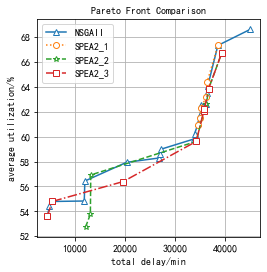

In [65]:
path = "C:\\Users\\64513\\Desktop\\zhengnanxi\\scheduling_of_rfl\\result\\case1_time3"
NSGAIITotalDelay, NSGAIIUtilization = readScatterData(path + "\\NSGAII\\ParetoFront.txt")
SPEA2_1TotalDelay, SPEA2_1Utilization = readScatterData(path + "\\SPEA2_1\\ParetoFront.txt")
SPEA2_2TotalDelay, SPEA2_2Utilization = readScatterData(path + "\\SPEA2_2\\ParetoFront.txt")
SPEA2_3TotalDelay, SPEA2_3Utilization = readScatterData(path + "\\SPEA2_3\\ParetoFront.txt")
NSGAIITotalDelay.sort()
NSGAIIUtilization.sort()
SPEA2_1TotalDelay.sort()
SPEA2_1Utilization.sort()
SPEA2_2TotalDelay.sort()
SPEA2_2Utilization.sort()
SPEA2_3TotalDelay.sort()
SPEA2_3Utilization.sort()
fig = plt.figure(1, figsize=(4,4))
plt.rcParams['font.sans-serif'] = ['SimHei'] #显示中文
plt.plot(NSGAIITotalDelay, NSGAIIUtilization, marker='^', markersize='6', markerfacecolor='w', ls='-', label='NSGAII')
plt.plot(SPEA2_1TotalDelay, SPEA2_1Utilization, marker='o', markersize='6', markerfacecolor='w', ls=':', label='SPEA2_1')
plt.plot(SPEA2_2TotalDelay, SPEA2_2Utilization, marker='*', markersize='6', markerfacecolor='w', ls='--', label='SPEA2_2')
plt.plot(SPEA2_3TotalDelay, SPEA2_3Utilization, marker='s', markersize='6', markerfacecolor='w', ls='-.', label='SPEA2_3')
plt.xlabel("total delay/min", fontdict={'size': 12}, fontproperties='SimHei')
plt.ylabel("average utilization/%", fontdict={'size': 12}, fontproperties='SimHei')
plt.title("Pareto Front Comparison", fontdict={'size': 14}, fontproperties='SimHei')
plt.legend(loc='best')
plt.grid()
plt.savefig(path + "\\算法最优解比较图.png", format='png')
print('NSGAII：\t%d个Pareto解' % len(NSGAIITotalDelay))
print('SPEA2_1：\t%d个Pareto解' % len(SPEA2_1TotalDelay))
print('SPEA2_2：\t%d个Pareto解' % len(SPEA2_2TotalDelay))
print('SPEA2_3：\t%d个Pareto解' % len(SPEA2_3TotalDelay))

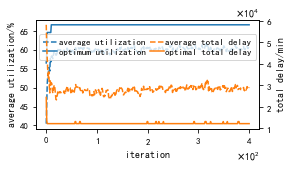

In [68]:
# %% 画nsgaii迭代曲线图
p = "C:\\Users\\64513\\Desktop\\zhengnanxi\\scheduling_of_rfl\\result\\case1_time3\\spea2_2"
utilization = []
totaldelay = []
toptotaldelay = []
toputilization = []
bottomtotaldelay = []
bottomutilization = []

with open(p + "\\uOfA.txt") as f:
    for line in f.readlines():
        utilization.append(json.loads(line))
with open(p + "\\tOfA.txt") as f:
    for line in f.readlines():
        totaldelay.append(json.loads(line))
with open(p + "\\topuOfA.txt") as f:
    for line in f.readlines():
        toputilization.append(json.loads(line))
with open(p + "\\bottomtOfA.txt") as f:
    for line in f.readlines():
        bottomtotaldelay.append(json.loads(line))
with open(p + "\\bottomuOfA.txt") as f:
    for line in f.readlines():
        bottomutilization.append(json.loads(line))
with open(p + "\\toptOfA.txt") as f:
    for line in f.readlines():
        toptotaldelay.append(json.loads(line))
fig = plt.figure(2, figsize=(4,2))
# plt.rcParams['font.sans-serif'] = ['SimHei'] #显示中文
# 绘制利用率
ax1 = fig.add_subplot(111)
line1 = ax1.plot(range(0,len(utilization)), utilization, color='C0', linestyle='--',label="average utilization")
line2 = ax1.plot(range(0,len(toputilization)), toputilization, color='C0', label="optimum utilization")
# line1 = ax1.plot(range(0,len(utilization)), utilization, color='grey', linestyle='--',label="average utilization")
# line2 = ax1.plot(range(0,len(toputilization)), toputilization, color='grey', label="optimum utilization")
# ax1.fill_between(range(0,len(toputilization)), toputilization, bottomutilization, color='C0', alpha=.3, linewidth=0)
ax1.set_ylabel('average utilization/%', fontsize=10)
ax1.set_xlabel('iteration', fontsize=10)
ax1.tick_params(labelsize=9)
# ax1.legend(loc='best', handletextpad=0.2, labelspacing=0.2, borderpad=0.5)
# 绘制延期时间
ax2 = ax1.twinx()
line3 = ax2.plot(range(0,len(totaldelay)), totaldelay, color='C1', linestyle='--', label="average total delay")
line4 = ax2.plot(range(0,len(bottomtotaldelay)), bottomtotaldelay, color='C1', label="optimal total delay")
# line3 = ax2.plot(range(0,len(totaldelay)), totaldelay, color='black', linestyle='--', label="average total delay")
# line4 = ax2.plot(range(0,len(bottomtotaldelay)), bottomtotaldelay, color='black', label="optimal total delay")
# ax2.fill_between(range(0,len(toptotaldelay)), toptotaldelay, bottomtotaldelay, color='C1', alpha=.3, linewidth=0)
ax2.set_ylabel('total delay/min', fontsize=10)
ax2.tick_params(labelsize=9)
plt.ticklabel_format(style='sci',scilimits=(0,0), axis='both', useMathText=True)
# 合并图例
lines = line1 + line2 + line3 + line4
labels = [l.get_label() for l in lines]
# ax2.legend(loc='best', handletextpad=0.2, labelspacing=0.2, borderpad=0.5)
ax1.legend(
    lines, labels, ncol=2,
    handlelength=1.5, handletextpad=0.2, labelspacing=0.2, borderpad=0.5, columnspacing=0.5, borderaxespad=1,
    fontsize=9, 
    loc='center', bbox_to_anchor=(0.5, 0.75)
)
# plt.title('迭代曲线图')
plt.savefig(p + "\\迭代曲线图.png", format='png')
plt.show()

In [49]:
#%% 前沿面C-metric
c = 0
for i in range(len(NSGAIITotalDelay)):
    for j in range(len(SPEA2_1TotalDelay)):
        if NSGAIIUtilization[i] <= SPEA2_1Utilization[j] and NSGAIITotalDelay[i] > SPEA2_1TotalDelay[j] or NSGAIIUtilization[i] < SPEA2_1Utilization[j] and NSGAIITotalDelay[i] == SPEA2_1TotalDelay[j]:
            c+=1
            break
c = c/len(NSGAIITotalDelay)
print('C(SPEA2_1, NSGAII) = %f, ' % c, end=' ')
c = 0
for i in range(len(SPEA2_1Utilization)):
    for j in range(len(NSGAIITotalDelay)):
        if NSGAIIUtilization[j] >= SPEA2_1Utilization[i] and NSGAIITotalDelay[j] < SPEA2_1TotalDelay[i] or NSGAIIUtilization[j] > SPEA2_1Utilization[i] and NSGAIITotalDelay[j] == SPEA2_1TotalDelay[i]:
            c+=1
            break
c = c/len(SPEA2_1Utilization)
print('C(NSGAII, SPEA2_1) = %f; ' % c)

c = 0
for i in range(len(NSGAIITotalDelay)):
    for j in range(len(SPEA2_2TotalDelay)):
        if NSGAIIUtilization[i] <= SPEA2_2Utilization[j] and NSGAIITotalDelay[i] > SPEA2_2TotalDelay[j] or NSGAIIUtilization[i] < SPEA2_2Utilization[j] and NSGAIITotalDelay[i] == SPEA2_2TotalDelay[j]:
            c+=1
            break
c = c/len(NSGAIITotalDelay)
print('C(SPEA2_2, NSGAII) = %f, ' % c, end=' ')
c = 0
for i in range(len(SPEA2_2Utilization)):
    for j in range(len(NSGAIITotalDelay)):
        if NSGAIIUtilization[j] >= SPEA2_2Utilization[i] and NSGAIITotalDelay[j] < SPEA2_2TotalDelay[i] or NSGAIIUtilization[j] > SPEA2_2Utilization[i] and NSGAIITotalDelay[j] == SPEA2_2TotalDelay[i]:
            c+=1
            break
c = c/len(SPEA2_2Utilization)
print('C(NSGAII, SPEA2_2) = %f; ' % c)

c = 0
for i in range(len(NSGAIITotalDelay)):
    for j in range(len(SPEA2_3TotalDelay)):
        if NSGAIIUtilization[i] <= SPEA2_3Utilization[j] and NSGAIITotalDelay[i] > SPEA2_3TotalDelay[j] or NSGAIIUtilization[i] < SPEA2_3Utilization[j] and NSGAIITotalDelay[i] == SPEA2_3TotalDelay[j]:
            c+=1
            break
c = c/len(NSGAIITotalDelay)
print('C(SPEA2_3, NSGAII) = %f, ' % c, end=' ')
c = 0
for i in range(len(SPEA2_3Utilization)):
    for j in range(len(NSGAIITotalDelay)):
        if NSGAIIUtilization[j] >= SPEA2_3Utilization[i] and NSGAIITotalDelay[j] < SPEA2_3TotalDelay[i] or NSGAIIUtilization[j] > SPEA2_3Utilization[i] and NSGAIITotalDelay[j] == SPEA2_3TotalDelay[i]:
            c+=1
            break
c = c/len(SPEA2_3Utilization)
print('C(NSGAII, SPEA2_3) = %f. ' % c)

# %% 超体积指标HV
r_TotalDelay, r_Utilization = (1500000, 40)
NSGAIITotalDelay.insert(0, r_TotalDelay)
SPEA2_1TotalDelay.insert(0, r_TotalDelay)
SPEA2_2TotalDelay.insert(0, r_TotalDelay)
SPEA2_3TotalDelay.insert(0, r_TotalDelay)
NSGAIIUtilization.insert(0, r_Utilization)
SPEA2_1Utilization.insert(0, r_Utilization)
SPEA2_2Utilization.insert(0, r_Utilization)
SPEA2_3Utilization.insert(0, r_Utilization)
HV = 0
for i in range(1, len(NSGAIITotalDelay)):
    HV += (r_TotalDelay - NSGAIITotalDelay[i]) * (NSGAIIUtilization[i] - NSGAIIUtilization[i-1])
print('HV(NSGAII) =\t%-f, ' % HV)
HV = 0
for i in range(1, len(SPEA2_1TotalDelay)):
    HV += (r_TotalDelay - SPEA2_1TotalDelay[i]) * (SPEA2_1Utilization[i] - SPEA2_1Utilization[i-1])
print('HV(SPEA2_1) = \t%-f, ' % HV)
HV = 0
for i in range(1, len(SPEA2_2TotalDelay)):
    HV += (r_TotalDelay - SPEA2_2TotalDelay[i]) * (SPEA2_2Utilization[i] - SPEA2_2Utilization[i-1])
print('HV(SPEA2_2) =\t%-f. ' % HV)
HV = 0
for i in range(1, len(SPEA2_3TotalDelay)):
    HV += (r_TotalDelay - SPEA2_3TotalDelay[i]) * (SPEA2_3Utilization[i] - SPEA2_3Utilization[i-1])
print('HV(SPEA2_3) =\t%-f. ' % HV)

C(SPEA2_1, NSGAII) = 0.181818,  C(NSGAII, SPEA2_1) = 0.428571; 
C(SPEA2_2, NSGAII) = 0.863636,  C(NSGAII, SPEA2_2) = 0.125000; 
C(SPEA2_3, NSGAII) = 0.909091,  C(NSGAII, SPEA2_3) = 0.000000. 
HV(NSGAII) =	38433692.452626, 
HV(SPEA2_1) = 	36525624.952181, 
HV(SPEA2_2) =	40026510.875548. 
HV(SPEA2_3) =	40027360.931889. 


Text(0.5, 0, '总拖期时间/min')

Text(0, 0.5, '平均设备利用率/%')

Text(0.5, 1.0, '算法解散点图')

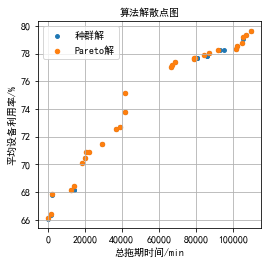

In [7]:
# %% 画散点图
p = ("E:\\JavaProjects\\configuration_and_scheduling_of_MRFL\\SPEA2\\sourse\\case3")
allTotalDelay, allUtilization = readAllScatterData(p + "\\archiveObj.txt")
TotalDelay, Utilization = readScatterData(p + "\\ParetoFront.txt")
# with open(p + "\\archiveObj.txt") as f:
#     lines = f.readlines()
#     line = lines[0]
#     scatterData = json.loads(line)
#     allTotalDelay, allUtilization = readScatterData(scatterData)
# with open(p + "\\ParetoFront.txt") as f:
#     lines = f.readlines()
#     line = lines[0]
#     scatterData = json.loads(line)
#     TotalDelay, Utilization = readScatterData(scatterData)
fig = plt.figure(1, figsize=(4,3.8))
plt.rcParams['font.sans-serif'] = ['SimHei'] #显示中文
plt.scatter(allTotalDelay, allUtilization, s=15, label='种群解')
plt.scatter(TotalDelay, Utilization, color='C1', s=20, label='Pareto解')
plt.xlabel("总拖期时间/min", fontdict={'size': 12}, fontproperties='SimHei')
plt.ylabel("平均设备利用率/%", fontdict={'size': 12}, fontproperties='SimHei')
plt.title("算法解散点图", fontdict={'size': 14}, fontproperties='SimHei')
plt.legend(loc='best')
plt.grid()
plt.savefig(p + "\\解散点图.png", format='png')

In [23]:
p = ("E:\\JavaProjects\\configuration_and_scheduling_of_MRFL\\SPEA2\\sourse\\case3")
allTotalDelay, allUtilization = readAllScatterData(p + "\\archiveObj.txt")
TotalDelay, Utilization = readScatterData(p + "\\ParetoFront.txt")
MINTotalDelay = min(TotalDelay)
MAXTotalDelay = max(TotalDelay)
MINUtilization = min(Utilization)
MAXUtilization = max(Utilization)
x = []
y = []
for i in range(len(TotalDelay)):
    x.append((TotalDelay[i] - MINTotalDelay)/(MAXTotalDelay - MINTotalDelay))
    y.append((Utilization[i] - MINUtilization)/(MAXUtilization - MINUtilization))
MINx = min(x)
MAXy = max(y)
gte = []
for i in range(len(TotalDelay)):
    gtey = abs(MAXy - y[i])
    gtex = abs(MINx - x[i])
    gtey,gtex
    gte.append(max(gtey,gtex))

(1.0, 0.0)

(0.8712199191815806, 0.019690063810391976)

(0.975572216745514, 0.017228805834092982)

(0.8497449006596485, 0.11536918869644484)

(0.8287880894387789, 0.13035551504102097)

(0.7037441420115715, 0.16603463992707385)

(0.6774776615176809, 0.18348222424794894)

(0.6476237925399373, 0.19019143117593437)

(0.646614263061394, 0.2024430264357338)

(0.6034027491166561, 0.2678760255241568)

(0.522197418089362, 0.33429352780309934)

(0.5129843972357869, 0.35686417502278944)

(0.33372431482998954, 0.3822971741112124)

(0.431099853032172, 0.37797629899726526)

(0.19439934813331583, 0.6048678213309024)

(0.18067653449892662, 0.6125250683682771)

(0.16638193696310488, 0.624102096627165)

(0.14886081878727164, 0.7177757520510483)

(0.1467383945940155, 0.7202370100273473)

(0.1428254174547371, 0.726982680036463)

(0.12931402866684794, 0.76718322698268)

(0.1164816020496422, 0.7923792160437557)

(0.10134158289754946, 0.8374658158614403)

(0.0816825903404318, 0.9318505013673656)

(0.0955742284735498, 0.9284776663628077)

(0.033002035024726206, 0.9594165907019143)

(0.06267111217394705, 0.9568094804010939)

(0.024356192516033603, 0.9745852324521422)

(0.0, 1.0)

In [25]:
gte
min(gte)

[1.0,
 0.8712199191815806,
 0.975572216745514,
 0.8497449006596485,
 0.8287880894387789,
 0.7037441420115715,
 0.6774776615176809,
 0.6476237925399373,
 0.646614263061394,
 0.6034027491166561,
 0.522197418089362,
 0.5129843972357869,
 0.3822971741112124,
 0.431099853032172,
 0.6048678213309024,
 0.6125250683682771,
 0.624102096627165,
 0.7177757520510483,
 0.7202370100273473,
 0.726982680036463,
 0.76718322698268,
 0.7923792160437557,
 0.8374658158614403,
 0.9318505013673656,
 0.9284776663628077,
 0.9594165907019143,
 0.9568094804010939,
 0.9745852324521422,
 1.0]

0.3822971741112124